In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-09-27 11:56:05.881474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 11:56:06.510134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

In [2]:
# hardcoded stuff
df_path = "data/otu_table_example.csv"

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [3]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [4]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

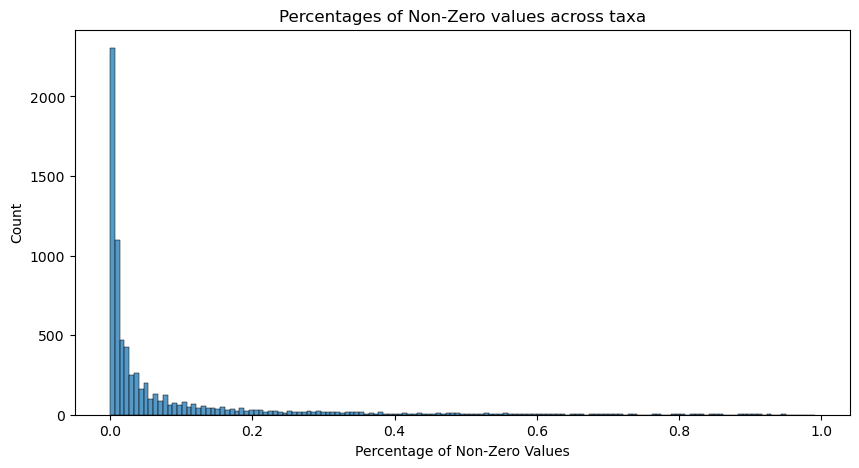

In [5]:
non_zero_value_counts = pd.Series([len(df[col][df[col] != 0]) for col in df.columns])
non_zero_value_pcts = non_zero_value_counts / len(df)

plt.figure(figsize=(10,5))
sns.histplot(non_zero_value_pcts)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

In [6]:
non_zero_value_counts.describe()

count   7244.000000
mean      38.409856
std       71.884313
min        0.000000
25%        3.000000
50%        9.000000
75%       37.000000
max      516.000000
dtype: float64

### Preprocessing

In [7]:
def preprocess(df, zero_values_percentage_cutoff, smoothing_window_size):

    # get rid of features that are way too sparse
    zero_counts = pd.Series([sum(df[col] == 0) for col in df.columns], index=df.columns)
    zero_pcts = zero_counts / len(df)
    populated_feats = zero_pcts[zero_pcts < zero_values_percentage_cutoff].index
    df = df[populated_feats]
    
    # smooth the data my forward-rolling averaging
    df = smooth_it_out(df=df, window_size=smoothing_window_size)
    
    # scale the data
    df = feature_wise_scaling(df)
    
    return df

Here is how an example taxa with id 302746 looks like before preprocessing

In [9]:
def plot_a_taxa_sequence(sequence, color, title, figsize=(10,5)):

    plt.figure(figsize=figsize)
    sns.lineplot(sequence, color=color)
    plt.title(title)
       
    plt.show()

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


In [9]:
example_taxa_idx = 302746
example_taxa_sequence_raw = df[example_taxa_idx]

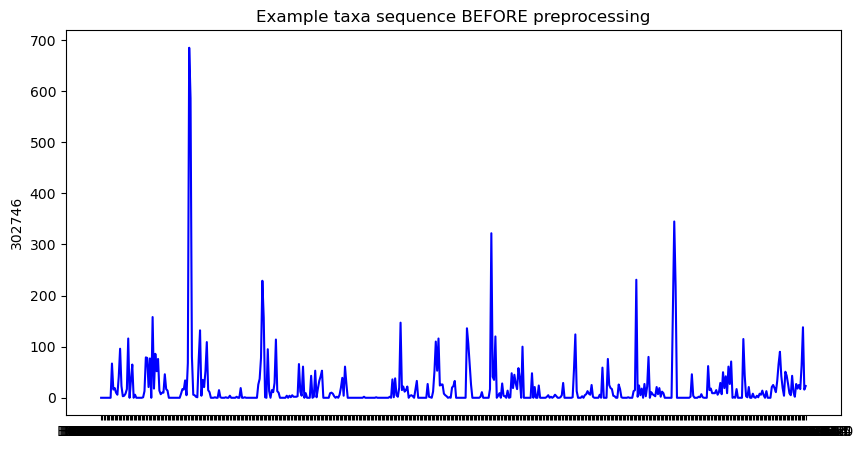

In [10]:
zero_values_percentage_cutoff = 0.5 # at least 50% of taxa must be non-zero values
smoothing_window_size = 5
df = preprocess(df, zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

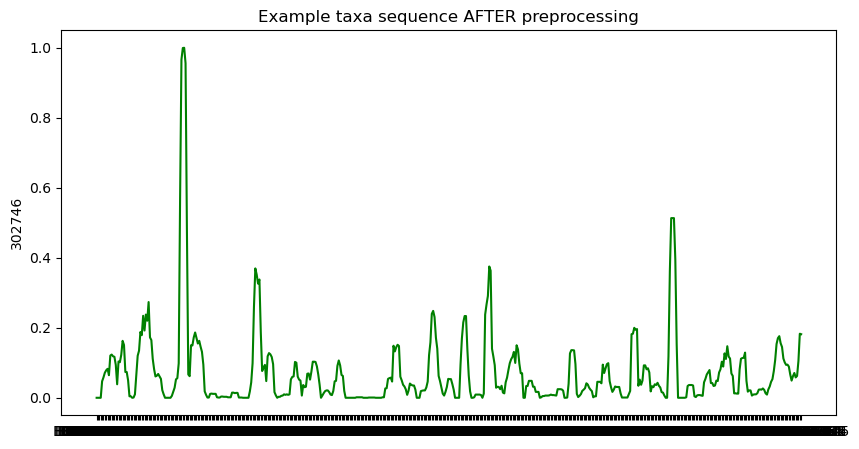

In [11]:
example_taxa_sequence_preprocessed = df[example_taxa_idx]
df

#### Here is what our example taxa sequence 302746 looks like after preprocessing

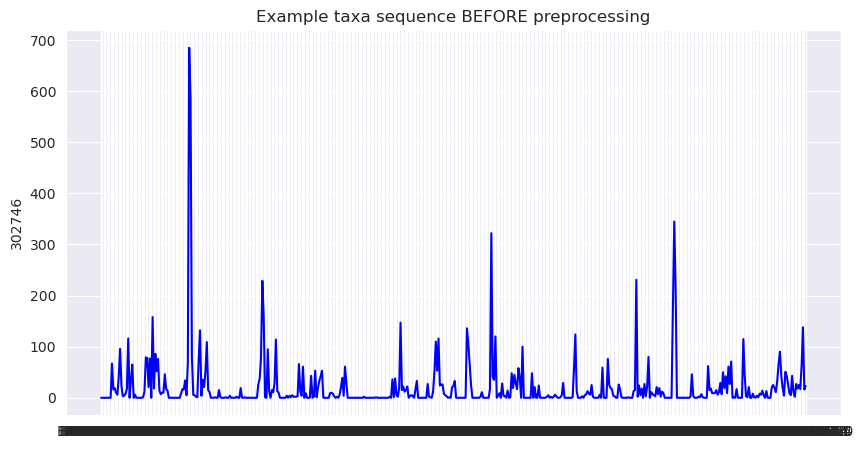

In [12]:
plot_a_taxa_sequence(sequence=example_taxa_sequence_raw, color="blue", title="Example taxa sequence BEFORE preprocessing")

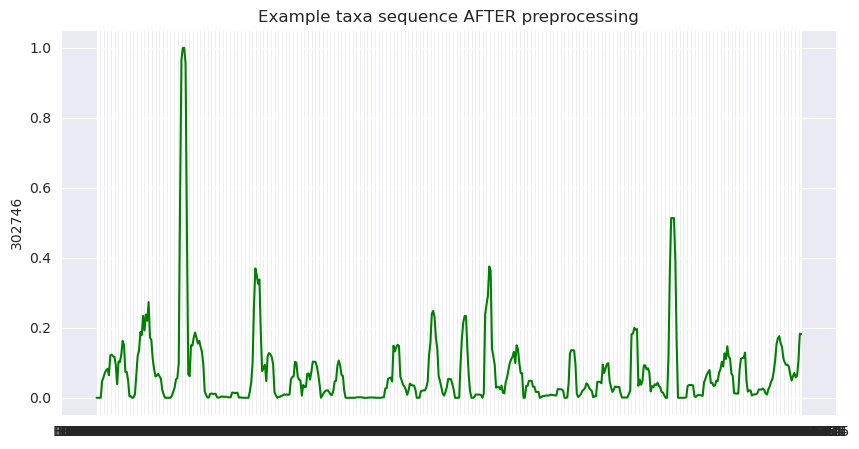

In [13]:
plot_a_taxa_sequence(sequence=example_taxa_sequence_preprocessed, color="green", title="Example taxa sequence AFTER preprocessing")

### Features and Targets

Now I prepare feature sequences and target sequences. For a detailed description of how this happens please read the description to function cut_to_sequences(). You will find it in functions.py

Every sequence before cutoff is used for training. Every sequence after: for testing

In [14]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 466
Train sequences: 411
Test sequences: 55


### The Model

In [15]:
reg = 1e-12
loss=mae_ignore_zeros

n_feats = len(df.columns)

model = Sequential()
model.add(keras.Input(shape=(seq_length, n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

2023-09-26 21:06:21.286883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 21:06:21.303510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 21:06:21.303770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              5025792   
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dense_1 (Dense)             (None, 202)               413898    
                                                                 
Total params: 7538890 (28.76 MB)
Trainable params: 7538890 (28.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [35]:
model.fit(x=X_sequences_train, y=y_targets_train, validation_split=0.05, epochs=10)

Epoch 1/10
13/13 [==============================] - 1s 50ms/step - loss: 0.1041 - mae: 0.0895 - mape: 3343136.7500 - val_loss: 0.0991 - val_mae: 0.0876 - val_mape: 1080602.6250
Epoch 2/10
13/13 [==============================] - 1s 49ms/step - loss: 0.1040 - mae: 0.0889 - mape: 2673653.7500 - val_loss: 0.0973 - val_mae: 0.0856 - val_mape: 1047038.0000
Epoch 3/10
13/13 [==============================] - 1s 48ms/step - loss: 0.1027 - mae: 0.0877 - mape: 2546653.7500 - val_loss: 0.0970 - val_mae: 0.0853 - val_mape: 1119251.1250
Epoch 4/10
13/13 [==============================] - 1s 49ms/step - loss: 0.1018 - mae: 0.0867 - mape: 2629943.7500 - val_loss: 0.0987 - val_mae: 0.0877 - val_mape: 783300.8750
Epoch 5/10
13/13 [==============================] - 1s 49ms/step - loss: 0.1009 - mae: 0.0861 - mape: 2566232.0000 - val_loss: 0.0959 - val_mae: 0.0838 - val_mape: 1137731.0000
Epoch 6/10
13/13 [==============================] - 1s 47ms/step - loss: 0.0996 - mae: 0.0846 - mape: 2386422.0000 -

In [36]:
y_pred = model.predict(X_sequences_test)

2/2 [==============================] - 0s 10ms/step


In [37]:
y_test_df = pd.DataFrame(y_targets_test)
y_pred_df = pd.DataFrame(y_pred)

In [38]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.037386,0.013270,0.436782,0.017225,0.147265,0.109215,0.615842,0.254545,0.009343,0.046296,...,0.268352,0.153846,0.021143,0.163265,0.053025,0.587819,0.082677,0.266264,0.265606,0.302326
1,0.019149,0.012742,0.344828,0.014833,0.117812,0.054608,0.483168,0.254545,0.009343,0.046296,...,0.238989,0.083333,0.021143,0.163265,0.040316,0.453091,0.062992,0.202535,0.222715,0.235880
2,0.012158,0.014207,0.264368,0.014354,0.112202,0.058020,0.843564,0.254545,0.018137,0.101852,...,0.196574,0.070513,0.020396,0.142857,0.076992,0.786066,0.055118,0.393724,0.255036,0.481728
3,0.008207,0.010511,0.103448,0.008134,0.069425,0.040956,0.506931,0.072727,0.096455,0.074074,...,0.079119,0.032051,0.018687,0.061224,0.062362,0.582744,0.055118,0.300905,0.142139,0.385382
4,0.008207,0.004054,0.057471,0.006699,0.062412,0.037543,0.435644,0.018182,0.089860,0.078704,...,0.061990,0.032051,0.050690,0.040816,0.058386,0.470624,0.059055,0.257333,0.089946,0.338870
5,0.001520,0.004940,0.137931,0.003349,0.012623,0.098976,0.475248,0.000000,0.089035,0.078704,...,0.013051,0.121795,0.128928,0.040816,0.056085,0.616887,0.192913,0.305854,0.089652,0.335548
6,0.001520,0.007478,0.137931,0.006220,0.012623,0.109215,0.487129,0.000000,0.092883,0.078704,...,0.013051,0.134615,0.147687,0.040816,0.056085,0.653491,0.212598,0.324321,0.100833,0.335548
7,0.000608,0.006712,0.091954,0.008612,0.011921,0.112628,0.077228,0.000000,0.244573,0.013889,...,0.004894,0.179487,0.172972,0.020408,0.004221,0.257767,0.204724,0.107423,0.037753,0.049834
8,0.000000,0.006184,0.114943,0.008134,0.011921,0.129693,0.073267,0.000000,0.165155,0.004630,...,0.000816,0.185897,0.173140,0.000000,0.000424,0.246386,0.200787,0.107906,0.070708,0.003322
9,0.000000,0.006490,0.229885,0.016268,0.080645,0.133106,0.089109,0.000000,0.169827,0.000000,...,0.267537,0.160256,0.132155,0.000000,0.009225,0.261150,0.200787,0.126735,0.127246,0.000000


In [39]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.039852,0.000000,0.159055,0.000000,0.025661,0.086990,0.147527,0.247557,0.096254,0.234606,...,0.325492,0.088322,0.000000,0.245201,0.000000,0.212266,0.098620,0.147272,0.215509,0.162302
1,0.034306,0.000000,0.151478,0.000000,0.022948,0.084014,0.135865,0.239535,0.088778,0.227119,...,0.305372,0.085379,0.000000,0.239298,0.000000,0.198299,0.097204,0.138294,0.199830,0.159477
2,0.021906,0.000000,0.119338,0.000000,0.015409,0.072606,0.097636,0.183496,0.062172,0.175337,...,0.221131,0.065196,0.000000,0.189245,0.000000,0.147683,0.079951,0.107930,0.146924,0.130177
3,0.029687,0.000000,0.134578,0.000000,0.018329,0.075021,0.122399,0.193608,0.078205,0.186699,...,0.264060,0.070854,0.000000,0.194224,0.000000,0.178050,0.081908,0.126832,0.181127,0.136381
4,0.019498,0.000000,0.105525,0.000000,0.008925,0.061450,0.090069,0.144420,0.054389,0.140811,...,0.186910,0.049815,0.000000,0.150496,0.000000,0.135004,0.062393,0.101062,0.139075,0.109314
5,0.017340,0.000000,0.102791,0.000000,0.006021,0.059497,0.084989,0.138255,0.049722,0.135838,...,0.174761,0.047285,0.000000,0.147190,0.000000,0.128255,0.061511,0.097025,0.132410,0.104742
6,0.016084,0.000000,0.094416,0.000000,0.004489,0.057579,0.075470,0.115694,0.041397,0.115347,...,0.148667,0.040903,0.000000,0.127346,0.000000,0.113827,0.056640,0.088978,0.117299,0.090999
7,0.017140,0.000000,0.098352,0.000000,0.003574,0.058831,0.077775,0.120983,0.041443,0.120557,...,0.152571,0.042791,0.000000,0.134643,0.000000,0.116454,0.060000,0.090752,0.120172,0.092004
8,0.006411,0.000000,0.076958,0.019083,0.000000,0.053679,0.044008,0.089754,0.016284,0.090792,...,0.084870,0.032389,0.000000,0.112992,0.000000,0.072755,0.055976,0.063930,0.071324,0.072806
9,0.002951,0.000000,0.072018,0.027722,0.000000,0.052533,0.033376,0.073764,0.005988,0.077036,...,0.060354,0.029656,0.000000,0.103009,0.000000,0.057802,0.057377,0.055069,0.054050,0.062102


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [40]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 34, 16.831683168316832% of all taxa


The next section allows to examine individual true and predicted sequences

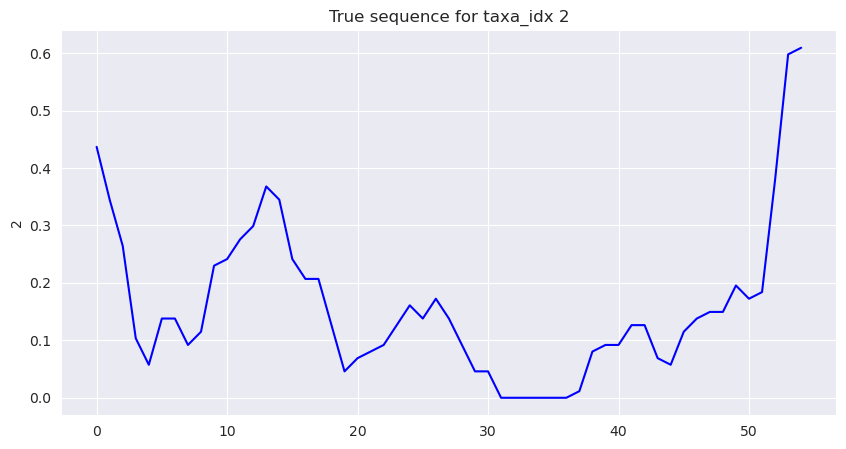

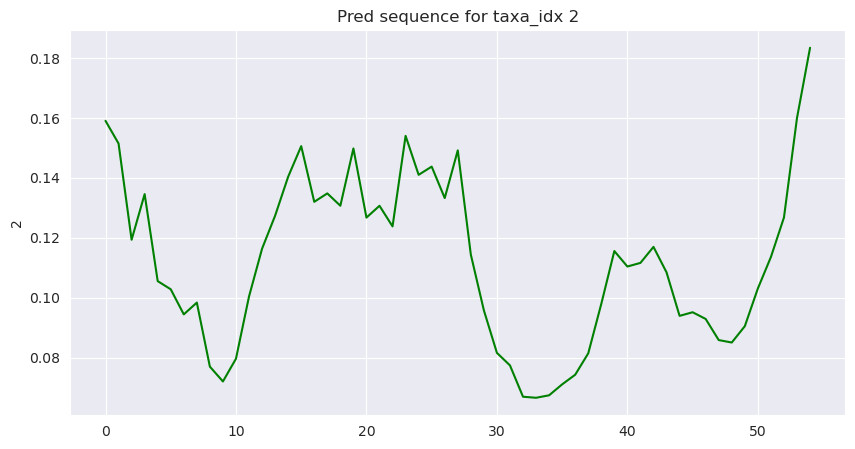

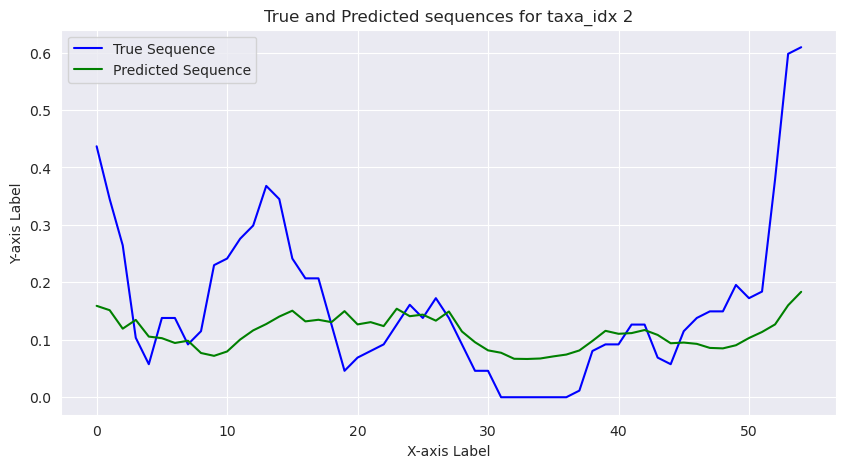

In [41]:
target_taxa = 2
true_sequence = y_test_df[target_taxa]
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences

In [25]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,36142582.597124,2249847427.535937,0.770201,59504132.150071,2.092320,0.591485,1.729589,0.773008,2.377152,0.530826,...,0.607087,1.404425,275645414.306284,0.613584,517579351.481066,0.982803,1.057742,0.649355,0.632798,1.149518
std,169425607.462783,2965623042.675204,0.670451,91465894.519004,1.869677,0.351364,2.163173,0.846927,1.705685,0.292363,...,0.439784,1.615565,439008988.533403,0.540963,424151646.516404,0.986991,1.141424,0.569654,0.584017,1.231867
min,0.133123,40543762.873899,0.018957,0.094135,0.168809,0.018653,0.048052,0.004749,0.025124,0.020155,...,0.014815,0.005694,240807.182471,0.015315,223358.867715,0.023367,0.014282,0.007201,0.019344,0.002579
25%,0.949419,160386356.074687,0.327292,0.541951,0.499774,0.313495,0.265987,0.214093,0.989134,0.325694,...,0.280221,0.385826,16134081.225577,0.202369,141497842.697699,0.301906,0.274977,0.197396,0.187061,0.317985
50%,1.000000,1148512812.167328,0.521647,3.848516,1.748671,0.584070,0.557771,0.615808,2.254355,0.501611,...,0.549680,0.745139,41418835.385064,0.566737,452078348.255947,0.573041,0.615210,0.437848,0.420776,0.802432
75%,3.209193,2916510471.775547,1.000000,90909089.695324,3.007147,0.849921,3.157077,1.000000,3.654614,0.720517,...,0.836176,1.848058,402750012.683250,0.833810,784771381.718019,1.372129,1.206873,0.990877,0.998356,1.322884
max,896656522.982759,9999999866.485682,2.573313,368421047.712630,7.063781,1.581054,7.370606,3.731589,7.407213,1.294922,...,2.232993,7.175957,1731403641.968648,2.605903,1445355232.986282,4.592223,5.283382,2.511327,2.301471,5.611080


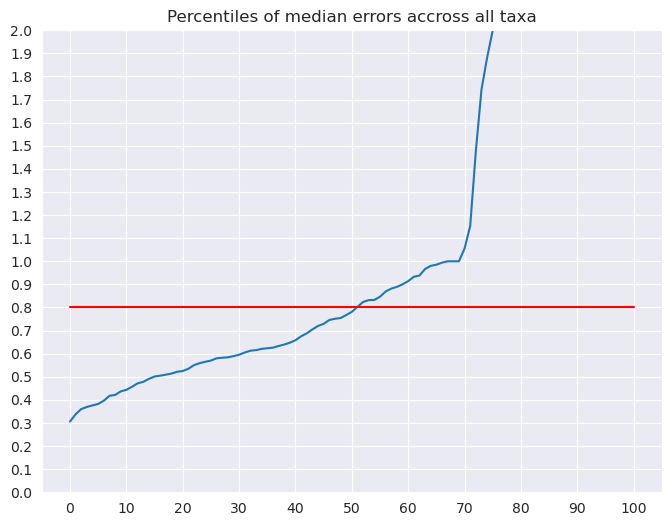

In [30]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=2, x_percentile=0.8)

Same graph, but only for those taxa that are not all predicted zero

In [28]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,0,2,3,4,5,6,7,8,9,10,...,187,191,192,193,195,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,36142582.597124,0.770201,59504132.150071,2.092320,0.591485,1.729589,0.773008,2.377152,0.530826,1.508439,...,0.607228,0.740074,0.607087,1.404425,0.613584,0.982803,1.057742,0.649355,0.632798,1.149518
std,169425607.462783,0.670451,91465894.519004,1.869677,0.351364,2.163173,0.846927,1.705685,0.292363,1.438509,...,0.354476,0.470190,0.439784,1.615565,0.540963,0.986991,1.141424,0.569654,0.584017,1.231867
min,0.133123,0.018957,0.094135,0.168809,0.018653,0.048052,0.004749,0.025124,0.020155,0.042169,...,0.022195,0.002809,0.014815,0.005694,0.015315,0.023367,0.014282,0.007201,0.019344,0.002579
25%,0.949419,0.327292,0.541951,0.499774,0.313495,0.265987,0.214093,0.989134,0.325694,0.493275,...,0.325379,0.371896,0.280221,0.385826,0.202369,0.301906,0.274977,0.197396,0.187061,0.317985
50%,1.000000,0.521647,3.848516,1.748671,0.584070,0.557771,0.615808,2.254355,0.501611,0.859440,...,0.609537,0.751751,0.549680,0.745139,0.566737,0.573041,0.615210,0.437848,0.420776,0.802432
75%,3.209193,1.000000,90909089.695324,3.007147,0.849921,3.157077,1.000000,3.654614,0.720517,1.986353,...,0.850463,0.946633,0.836176,1.848058,0.833810,1.372129,1.206873,0.990877,0.998356,1.322884
max,896656522.982759,2.573313,368421047.712630,7.063781,1.581054,7.370606,3.731589,7.407213,1.294922,5.660747,...,1.670907,2.288343,2.232993,7.175957,2.605903,4.592223,5.283382,2.511327,2.301471,5.611080


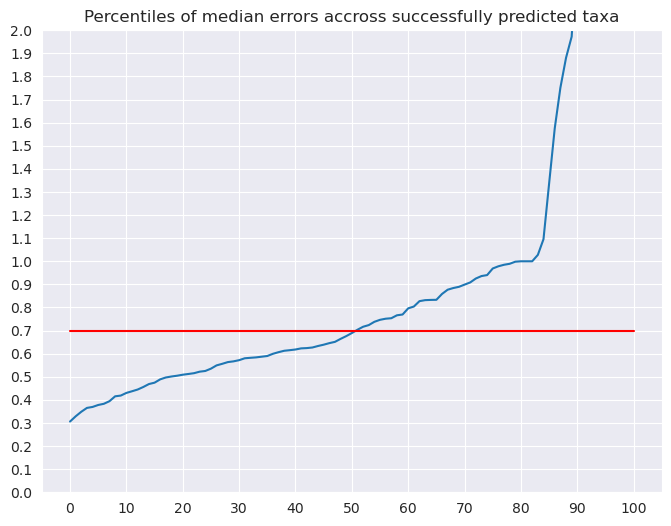

In [32]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=2, x_percentile=0.7)